In [1]:
!pip install transformers

In [2]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.layers import Dropout, TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import MobileBertTokenizer, TFMobileBertForSequenceClassification
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import graphviz
import re
from sklearn import metrics
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

In [3]:
def read_ann_file(file_path):
    text_data = []
    event_data = []

    with open(file_path, 'r') as file:
        for line in file:
            line_parts = line.strip().split('\t')
            prefix = line_parts[0][0]

            if prefix == 'T':
                identifier, label_info, *text_parts = line_parts
                text = ' '.join(text_parts)  # Combine all text parts
                label_info_parts = label_info.split()
                label = label_info_parts[0]
                starts = [int(s) for s in label_info_parts[1].split(';')]
                ends = [int(e) for e in label_info_parts[2].split(';')]
                text_data.append([identifier, label, starts, ends, text])

            elif prefix == 'E':
                identifier, event_info = line_parts
                event_parts = event_info.split()
                label = event_parts[0].split(':')[0]

                if len(event_parts) > 4:  # Handle the case when there's an additional 'Means' part
                    event_parts[4:] = [' '.join(event_parts[4:])]

                event_data.append([identifier, label] + event_parts)

    text_df = pd.DataFrame(text_data, columns=['ID', 'Label', 'Start', 'End', 'Text'])

    # Determine the maximum number of columns needed for event_df
    max_event_columns = max([len(row) for row in event_data])
    event_columns = ['ID', 'Label'] + [f'Arg{i}' for i in range(1, max_event_columns - 1)]

    event_df = pd.DataFrame(event_data, columns=event_columns)

    return text_df, event_df

In [4]:
def read_data(path):

    drive.mount('/content/drive')
    files = [f for f in os.listdir(path)]
    event_df, text_df = [], []

    for file in files:
      file_path = os.path.join(path, file)
      text, event = read_ann_file(file_path)
      text["isCausal"] = 0
      for index, row in event.iterrows():
        for x in range(2,5):
          if not isinstance(row[x], type(None)):
            labels = row.iloc[x].split(':')
            if labels[0] == "Cause":
              text.loc[text['ID'] == labels[1], 'isCausal'] = 1

      event_df.append(event)
      text_df.append(text)

    return pd.concat(text_df, ignore_index=True), pd.concat(event_df, ignore_index=True)


In [5]:
text, event = read_data("/content/drive/MyDrive/Course/NLP/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(event)

       ID        Label             Arg1        Arg2        Arg3 Arg4 Arg5
0      E1      Purpose       Purpose:T1    Cause:T2   Effect:T3  NaN  NaN
1      E2  Consequence   Consequence:T4    Cause:T5   Effect:T6  NaN  NaN
2      E4  Consequence  Consequence:T10   Cause:T11  Effect:T12  NaN  NaN
3      E6   Motivation   Motivation:T15  Effect:T16        None  NaN  NaN
4      E7      Purpose      Purpose:T21   Cause:T22  Effect:T23  NaN  NaN
...   ...          ...              ...         ...         ...  ...  ...
2382  E18   Motivation   Motivation:T51   Cause:T52  Effect:T53  NaN  NaN
2383  E19  Consequence  Consequence:T38   Cause:T54  Effect:T56  NaN  NaN
2384   E1   Motivation    Motivation:T1   Effect:T2        None  NaN  NaN
2385   E2  Consequence   Consequence:T3    Cause:T4   Effect:T5  NaN  NaN
2386   E3    NonCausal     NonCausal:T6     Arg1:T7        None  NaN  NaN

[2387 rows x 7 columns]


In [7]:
print(text)

      ID        Label  Start    End  \
0     T1      Purpose  [587]  [589]   
1     T2     Argument  [590]  [666]   
2     T3     Argument  [555]  [586]   
3     T4  Consequence  [724]  [729]   
4     T5     Argument  [730]  [827]   
...   ..          ...    ...    ...   
7173  T4     Argument  [656]  [697]   
7174  T5     Argument  [699]  [816]   
7175  T6    NonCausal  [802]  [808]   
7176  T7     Argument  [699]  [801]   
7177  T8         Note  [745]  [747]   

                                                   Text  isCausal  
0                                                    so         0  
1     the judge, Oscar Magi, could decide whether to...         1  
2                       the trial adjourned for 10 days         0  
3                                                 while         0  
4     the Constitutional Court rules on whether pros...         1  
...                                                 ...       ...  
7173          the court grants a preliminary injunction

In [8]:
df = text.drop(columns=['ID', 'Start', 'End'])
print(df.shape)

(7178, 3)


In [9]:
# encoding labels
classes = np.unique(text['Label'].values)
print(classes)
le = LabelEncoder()
le.fit(classes)
encoded_labels = le.transform(text['Label'].values)
df['EncodedLabels'] = encoded_labels

['Argument' 'Consequence' 'Motivation' 'NonCausal' 'Note' 'Purpose']


In [10]:
# text cleaning
# from https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

contractions_dict = {'ain\'t': 'are not', 'aren\'t': 'are not', 'can\'t': 'cannot', 'can\'t\'ve': 'cannot have', '\'cause': 'because',
                     'could\'ve': 'could have', 'couldn\'t': 'could not', 'couldn\'t\'ve': 'could not have', 'didn\'t': 'did not',
                     'doesn\'t': 'does not', 'don\'t': 'do not', 'hadn\'t': 'had not', 'hadn\'t\'ve': 'had not have', 'hasn\'t': 'has not',
                     'haven\'t': 'have not', 'he\'d': 'he would', 'he\'d\'ve': 'he would have','he\'ll': 'he will',
                     'he\'ll\'ve': 'he will have', 'how\'d': 'how did', 'how\'d\'y': 'how do you', 'how\'ll': 'how will', 'I\'d': 'I would',
                     'I\'d\'ve': 'I would have', 'I\'ll': 'I will', 'I\'ll\'ve': 'I will have', 'I\'m': 'I am', 'I\'ve': 'I have',
                     'isn\'t': 'is not', 'it\'d': 'it would', 'it\'d\'ve': 'it would have', 'it\'ll': 'it will', 'it\'ll\'ve': 'it will have',
                     'let\'s': 'let us', 'ma\'am': 'madam', 'mayn\'t': 'may not', 'might\'ve': 'might have', 'mightn\'t': 'might not',
                     'mightn\'t\'ve': 'might not have', 'must\'ve': 'must have', 'mustn\'t': 'must not', 'mustn\'t\'ve': 'must not have',
                     'needn\'t': 'need not', 'needn\'t\'ve': 'need not have', 'o\'clock': 'of the clock', 'oughtn\'t': 'ought not',
                     'oughtn\'t\'ve': 'ought not have', 'shan\'t': 'shall not', 'sha\'n\'t': 'shall not', 'shan\'t\'ve': 'shall not have',
                     'she\'d': 'she would', 'she\'d\'ve': 'she would have', 'she\'ll': 'she will', 'she\'ll\'ve': 'she will have',
                     'should\'ve': 'should have', 'shouldn\'t': 'should not', 'shouldn\'t\'ve': 'should not have', 'so\'ve': 'so have',
                     'that\'d': 'that would', 'that\'d\'ve': 'that would have', 'there\'d': 'there would', 'there\'d\'ve': 'there would have',
                     'they\'d': 'they would', 'they\'d\'ve': 'they would have','they\'ll': 'they will', 'they\'ll\'ve': 'they will have',
                     'they\'re': 'they are', 'they\'ve': 'they have', 'to\'ve': 'to have', 'wasn\'t': 'was not', 'we\'d': 'we would',
                     'we\'d\'ve': 'we would have', 'we\'ll': 'we will', 'we\'ll\'ve': 'we will have', 'we\'re': 'we are', 'we\'ve': 'we have',
                     'weren\'t': 'were not','what\'ll': 'what will', 'what\'ll\'ve': 'what will have', 'what\'re': 'what are',
                     'what\'ve': 'what have', 'when\'ve': 'when have', 'where\'d': 'where did', 'where\'ve': 'where have',
                     'who\'ll': 'who will', 'who\'ll\'ve': 'who will have', 'who\'ve': 'who have', 'why\'ve': 'why have',
                     'will\'ve': 'will have', 'won\'t': 'will not', 'won\'t\'ve': 'will not have', 'would\'ve': 'would have',
                     'wouldn\'t': 'would not', 'wouldn\'t\'ve': 'would not have', 'y\'all': 'you all', 'y\'all\'d': 'you all would',
                     'y\'all\'d\'ve': 'you all would have', 'y\'all\'re': 'you all are', 'y\'all\'ve': 'you all have', 'you\'d': 'you would',
                     'you\'d\'ve': 'you would have', 'you\'ll': 'you will', 'you\'ll\'ve': 'you will have', 'you\'re': 'you are',
                     'you\'ve': 'you have', 'it\'s' : 'it is', 'that\'s' : 'that is', '&' : 'and'
                     }

In [11]:
sentences = df['Text'].values

contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)




for i, sentence in enumerate(sentences):
  if i < 1000:
    print(sentence)
  sentence = expand_contractions(sentence)    # replace contrations
  words = sentence.split(' ')
  for j, word in enumerate(words):
    word = re.sub('[^a-zA-Z0-9]+', '', word)  # remove special characters
    word = word.lower()                       # to lower case
    words[j] = word

  sentence = ' '.join(words)
  sentence = re.sub(' +', ' ', sentence)      # remove multiple white spaces
  if i < 1000:
    print(sentence)
  sentences[i] = sentence

df['Text'] = sentences

so
so
the judge, Oscar Magi, could decide whether to suspend the trial temporarily
the judge oscar magi could decide whether to suspend the trial temporarily
the trial adjourned for 10 days
the trial adjourned for 10 days
while
while
the Constitutional Court rules on whether prosecutors violated state secrecy in bringing the case
the constitutional court rules on whether prosecutors violated state secrecy in bringing the case
the trial should be halted
the trial should be halted
After
after
the abduction in Milan
the abduction in milan
Mr. Nasr was jailed for four years in Egypt where he was tortured
mr nasr was jailed for four years in egypt where he was tortured
reason for
reason for
recruiting other members for their organizations
recruiting other members for their organizations
for
for
interrogation elsewhere
interrogation elsewhere
abducting terrorism suspects
abducting terrorism suspects
until
until
later this year
later this year
not expected
not expected
Then
then
the trial adj

In [12]:
# test to see if we want to delete duplicates
duplicates = df['Text'].duplicated().values
duplicates_in, counts = np.unique(duplicates, return_counts=True)

indices = np.where(duplicates == True)[0]

for i, d in enumerate(duplicates):
  if i > 500:
    break
  if d:
    for j in range(i):
      if df['Text'].values[i] == df['Text'].values[j] and df['Label'].values[i] != df['Label'].values[j]:
        print(df['Label'].values[i], df['Label'].values[j], '\t\t\t', df['Text'].values[j])
        break

indices_double = []
dataset_size = df.shape[0]
for i, d in enumerate(tqdm(duplicates, desc='Finding duplicates')):
  if d:
    all_same = True
    for j in range(i + 1, dataset_size):
      if df['Text'].values[i] == df['Text'].values[j] and df['Label'].values[i] != df['Label'].values[j]:
        all_same = False
        break
    if all_same:
      indices_double.append(i)

#df = df.drop(indices_double)
#print(df)

print()
print()
print(f'There are {len(indices_double)} duplicates in the dataset')

Consequence NonCausal 			 until
Note Purpose 			 to
Purpose Note 			 to
NonCausal Motivation 			 as
Consequence Motivation 			 as
Consequence NonCausal 			 when
NonCausal Consequence 			 with
Purpose Note 			 to
Consequence Motivation 			 as
Purpose Note 			 to
Purpose Note 			 to
NonCausal Motivation 			 as
Consequence NonCausal 			 since
Purpose Note 			 to
Note Purpose 			 to
Note Purpose 			 to
Consequence Motivation 			 as
Purpose Note 			 to
NonCausal Consequence 			 after
Purpose Note 			 to
NonCausal Motivation 			 as
NonCausal Consequence 			 while
Purpose Note 			 to
NonCausal Motivation 			 as
Note Consequence 			 help
Purpose Note 			 to
NonCausal Consequence 			 since
Consequence NonCausal 			 until
NonCausal Consequence 			 when
Motivation Purpose 			 for
Purpose Note 			 to
Purpose Motivation 			 for
Motivation Consequence 			 if
Purpose Note 			 to
Motivation Purpose 			 for
NonCausal Consequence 			 after
Motivation Consequence 			 because
Consequence Motivation 			 as

Finding duplicates:   0%|          | 0/7178 [00:00<?, ?it/s]



There are 827 duplicates in the dataset


In [13]:
tokenizer = Tokenizer()

sentences = df.Text.values

tokenizer.fit_on_texts(sentences)
tokenized = tokenizer.texts_to_sequences(sentences)
sequence_len = 0
for seq in tokenized:
  if len(seq) > sequence_len:
    sequence_len = len(seq)

tokenized = pad_sequences(tokenized, maxlen=sequence_len, padding='post')

In [14]:
x = tokenized
y = df['EncodedLabels'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

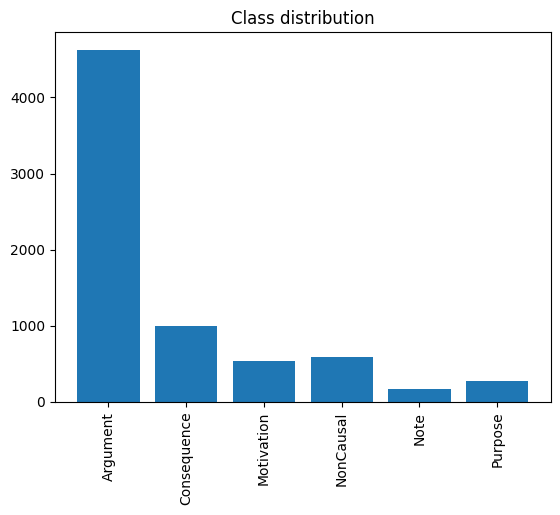

In [15]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, classes)
plt.title('Class distribution')
plt.xticks(unique, classes, rotation='vertical')
plt.savefig('causal_chaos/class_distribution')
plt.show()

1.0
Training set report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3715
           1       0.14      1.00      0.24       797
           2       0.00      0.00      0.00       424
           3       0.00      0.00      0.00       467
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00       212

    accuracy                           0.14      5742
   macro avg       0.02      0.17      0.04      5742
weighted avg       0.02      0.14      0.03      5742


Test set report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       914
           1       0.14      1.00      0.24       197
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00       117
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        60

    accuracy                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

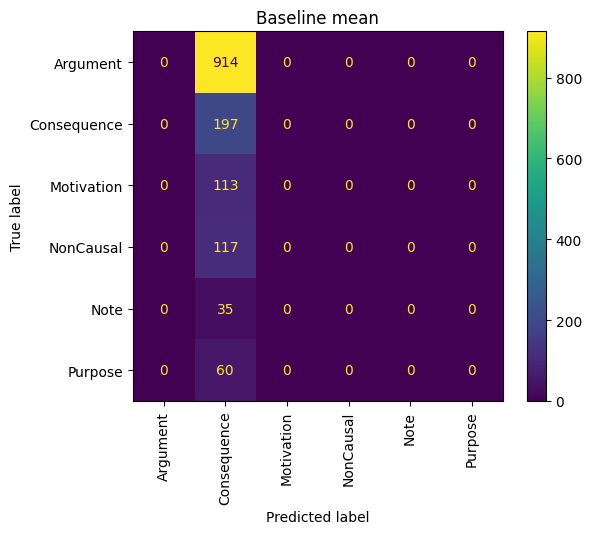

In [16]:
# baseline mean

y_mean = np.round(np.mean(y_train))
print(y_mean)

pred_train = np.ones_like(y_train) * y_mean
pred_test = np.ones_like(y_test) * y_mean

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Baseline mean')
plt.savefig('causal_chaos/confusion_matrix_baseline_mean')
plt.show()

0.0
Training set report
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      3715
           1       0.00      0.00      0.00       797
           2       0.00      0.00      0.00       424
           3       0.00      0.00      0.00       467
           4       0.00      0.00      0.00       127
           5       0.00      0.00      0.00       212

    accuracy                           0.65      5742
   macro avg       0.11      0.17      0.13      5742
weighted avg       0.42      0.65      0.51      5742


Test set report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       914
           1       0.00      0.00      0.00       197
           2       0.00      0.00      0.00       113
           3       0.00      0.00      0.00       117
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        60

    accuracy                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

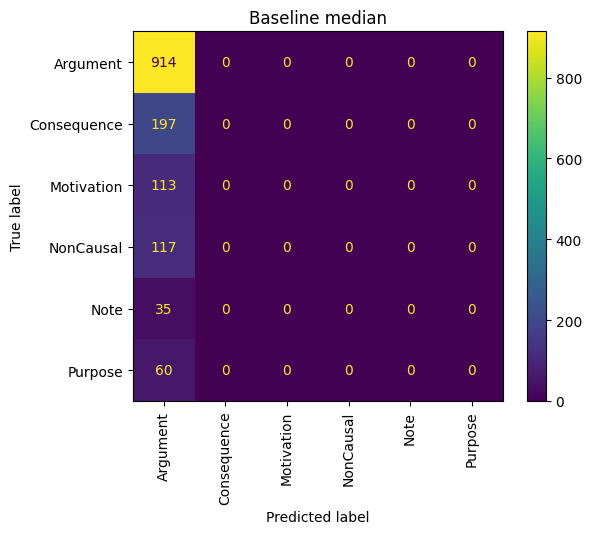

In [17]:
# baseline median

y_median = np.round(np.median(y_train))
print(y_median)

pred_train = np.ones_like(y_train) * y_median
pred_test = np.ones_like(y_test) * y_median

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Baseline median')
plt.savefig('causal_chaos/confusion_matrix_baseline_median')
plt.show()

Training set report
              precision    recall  f1-score   support

           0       0.65      0.17      0.27      3715
           1       0.14      0.16      0.15       797
           2       0.07      0.16      0.10       424
           3       0.08      0.17      0.11       467
           4       0.02      0.15      0.03       127
           5       0.03      0.15      0.05       212

    accuracy                           0.17      5742
   macro avg       0.17      0.16      0.12      5742
weighted avg       0.45      0.17      0.22      5742


Test set report
              precision    recall  f1-score   support

           0       0.61      0.15      0.24       914
           1       0.12      0.14      0.13       197
           2       0.07      0.14      0.09       113
           3       0.09      0.19      0.12       117
           4       0.03      0.20      0.05        35
           5       0.04      0.17      0.06        60

    accuracy                           0

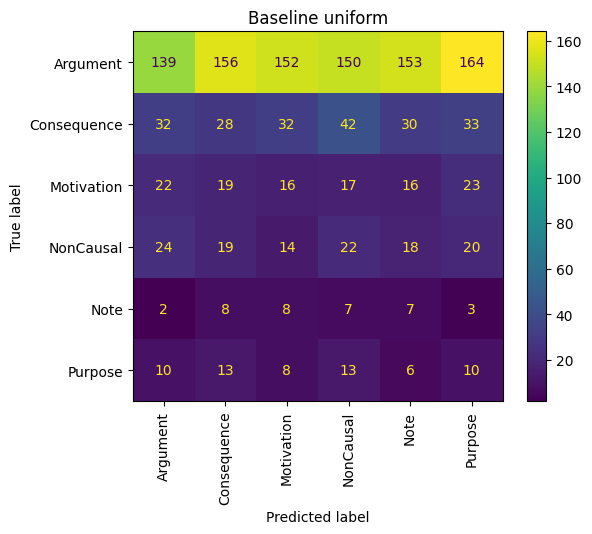

In [18]:
# baseline unform

pred_train = np.random.randint(classes.shape[0], size=y_train.shape)
pred_test = np.random.randint(classes.shape[0], size=y_test.shape)

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Baseline uniform')
plt.savefig('causal_chaos/confusion_matrix_baseline_uniform')
plt.show()

Training set report
              precision    recall  f1-score   support

           0       0.65      0.17      0.27      3715
           1       0.14      0.16      0.15       797
           2       0.08      0.17      0.10       424
           3       0.08      0.17      0.11       467
           4       0.03      0.22      0.05       127
           5       0.04      0.20      0.07       212

    accuracy                           0.17      5742
   macro avg       0.17      0.18      0.13      5742
weighted avg       0.46      0.17      0.21      5742


Test set report
              precision    recall  f1-score   support

           0       0.64      0.17      0.27       914
           1       0.17      0.20      0.18       197
           2       0.09      0.19      0.12       113
           3       0.08      0.17      0.11       117
           4       0.03      0.20      0.05        35
           5       0.06      0.23      0.09        60

    accuracy                           0

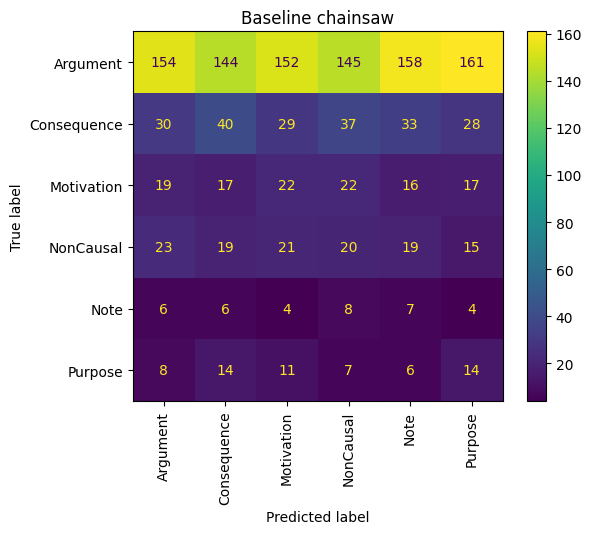

In [19]:
# baseline chainsaw

pred_train = np.zeros_like(y_train)
pred_test = np.zeros_like(y_test)

for i in range(classes.shape[0]):
  indices = np.arange(i, y_train.shape[0], classes.shape[0])
  pred_train[indices] = i
  indices = np.arange(i, y_test.shape[0], classes.shape[0])
  pred_test[indices] = i

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Baseline chainsaw')
plt.savefig('causal_chaos/confusion_matrix_baseline_chainsaw')
plt.show()

Training set report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3715
           1       0.80      0.77      0.79       797
           2       0.60      0.55      0.57       424
           3       0.65      0.91      0.76       467
           4       1.00      0.17      0.30       127
           5       0.83      0.80      0.81       212

    accuracy                           0.90      5742
   macro avg       0.81      0.70      0.70      5742
weighted avg       0.91      0.90      0.90      5742


Test set report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       914
           1       0.67      0.66      0.67       197
           2       0.53      0.43      0.48       113
           3       0.56      0.88      0.68       117
           4       0.00      0.00      0.00        35
           5       0.89      0.83      0.86        60

    accuracy                           0

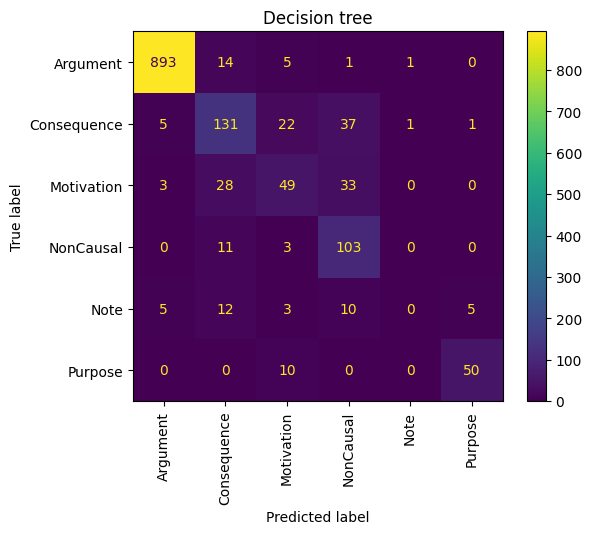

In [20]:
classifier1 = tree.DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)

pred_train = classifier1.predict(x_train)
pred_test = classifier1.predict(x_test)


print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Decision tree')
plt.show()

Training set report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3715
           1       0.81      0.77      0.79       797
           2       0.60      0.55      0.57       424
           3       0.65      0.91      0.76       467
           4       0.92      0.19      0.31       127
           5       0.83      0.80      0.81       212

    accuracy                           0.90      5742
   macro avg       0.80      0.70      0.71      5742
weighted avg       0.91      0.90      0.90      5742


Test set report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       914
           1       0.67      0.65      0.66       197
           2       0.55      0.42      0.48       113
           3       0.56      0.88      0.68       117
           4       0.33      0.03      0.05        35
           5       0.91      0.83      0.87        60

    accuracy                           0

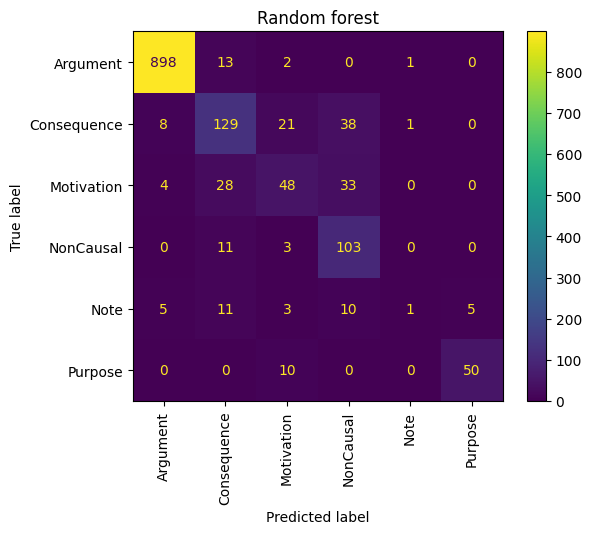

In [21]:
classifier2 = RandomForestClassifier(random_state=42).fit(x_train, y_train)

pred_train = classifier2.predict(x_train)
pred_test = classifier2.predict(x_test)

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))


cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Random forest')
plt.show()

In [22]:
x = tokenized
y = to_categorical(df['EncodedLabels'].values)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5742, 67)
(1436, 67)
(5742, 6)
(1436, 6)


Epoch 1/20
144/144 [==============================] - 37s 189ms/step - loss: 1.2886 - accuracy: 0.7000 - val_loss: 0.8763 - val_accuracy: 0.7424
Epoch 2/20
144/144 [==============================] - 27s 189ms/step - loss: 0.7209 - accuracy: 0.7810 - val_loss: 0.6782 - val_accuracy: 0.7911
Epoch 3/20
144/144 [==============================] - 30s 210ms/step - loss: 0.5871 - accuracy: 0.8134 - val_loss: 0.6149 - val_accuracy: 0.8007
Epoch 4/20
144/144 [==============================] - 26s 181ms/step - loss: 0.5348 - accuracy: 0.8226 - val_loss: 0.6577 - val_accuracy: 0.7685
Epoch 5/20
144/144 [==============================] - 26s 182ms/step - loss: 0.5162 - accuracy: 0.8287 - val_loss: 0.6093 - val_accuracy: 0.7990
Epoch 6/20
144/144 [==============================] - 28s 192ms/step - loss: 0.4945 - accuracy: 0.8284 - val_loss: 0.6274 - val_accuracy: 0.7868
Epoch 7/20
144/144 [==============================] - 26s 181ms/step - loss: 0.4816 - accuracy: 0.8341 - val_loss: 0.6353 - val_ac

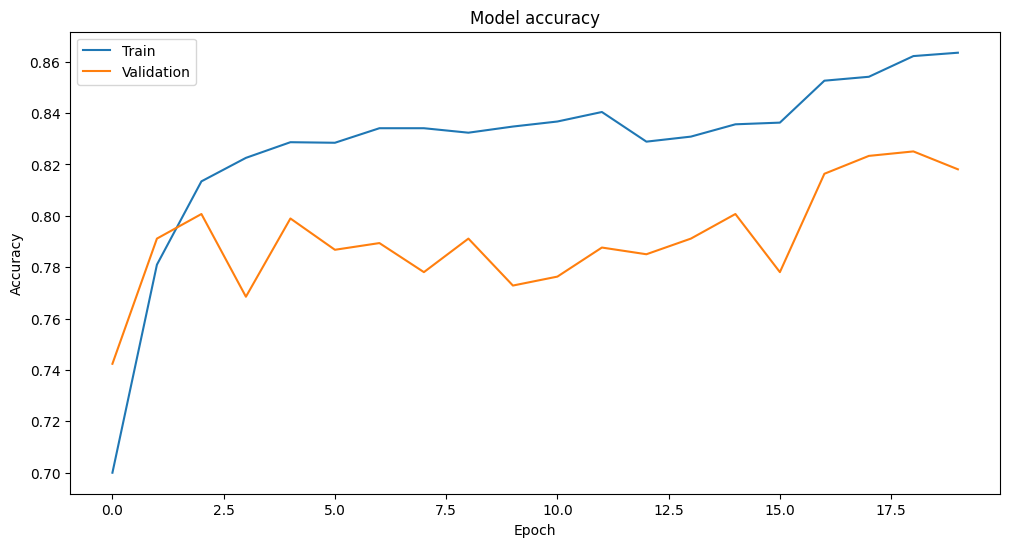

In [24]:
vocab_size = len(tokenizer.word_index)
embedding_dim = 100
max_sequence_length = x_train.shape[1]  # Set this to the same value you used for padding


model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2()),
    Dense(6, activation='softmax', kernel_regularizer=l2(), bias_regularizer=l2())
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(x_train, y_train, epochs=20, batch_size=32,  validation_split=0.2)

print(model1.summary())

print()
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
pred_train = model1.predict(x_train)
pred_test = model1.predict(x_test)

print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), np.argmax(pred_train, axis=1)))
print()
print('Test set report')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1)))

cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.title('LSTM')
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.show()

180/180 [==============================] - 8s 33ms/step


InvalidArgumentError: ignored

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

sentences = df.Text.values
tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]
df['Tokenized_Text'] = tokenized

sequence_len = 0
for seq in tokenized:
  if len(seq) > sequence_len:
    sequence_len = len(seq)

tokenized = pad_sequences(tokenized, maxlen=sequence_len, padding='post')

In [27]:
x = tokenized
y = df['EncodedLabels'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [28]:
results_df = pd.DataFrame({'Text': df['Text'],
                           'Label': df['Label']})
print(results_df)

                                                   Text        Label
0                                                    so      Purpose
1     the judge oscar magi could decide whether to s...     Argument
2                       the trial adjourned for 10 days     Argument
3                                                 while  Consequence
4     the constitutional court rules on whether pros...     Argument
...                                                 ...          ...
7173          the court grants a preliminary injunction     Argument
7174  the ftc must begin administrative proceedings ...     Argument
7175                                             within    NonCausal
7176  the ftc must begin administrative proceedings ...     Argument
7177                                                 to         Note

[7178 rows x 2 columns]


Training set report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3715
           1       0.80      0.77      0.79       797
           2       0.60      0.55      0.57       424
           3       0.65      0.91      0.76       467
           4       1.00      0.17      0.30       127
           5       0.83      0.80      0.81       212

    accuracy                           0.90      5742
   macro avg       0.81      0.70      0.70      5742
weighted avg       0.91      0.90      0.90      5742


Test set report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       914
           1       0.67      0.63      0.65       197
           2       0.54      0.42      0.48       113
           3       0.54      0.88      0.67       117
           4       0.00      0.00      0.00        35
           5       0.88      0.83      0.85        60

    accuracy                           0

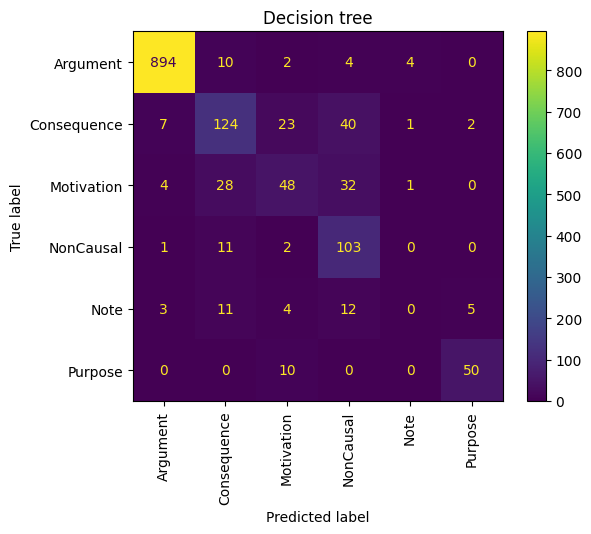

In [29]:
classifier1 = tree.DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)

pred_train = classifier1.predict(x_train)
pred_test = classifier1.predict(x_test)


print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))

cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Decision tree')
plt.savefig('causal_chaos/decision_tree')
plt.show()

In [30]:
pred = classifier1.predict(x)
pred_labels = le.inverse_transform(pred)
results_df['DecisionTreePredictions'] = pred_labels
print(results_df)

                                                   Text        Label  \
0                                                    so      Purpose   
1     the judge oscar magi could decide whether to s...     Argument   
2                       the trial adjourned for 10 days     Argument   
3                                                 while  Consequence   
4     the constitutional court rules on whether pros...     Argument   
...                                                 ...          ...   
7173          the court grants a preliminary injunction     Argument   
7174  the ftc must begin administrative proceedings ...     Argument   
7175                                             within    NonCausal   
7176  the ftc must begin administrative proceedings ...     Argument   
7177                                                 to         Note   

     DecisionTreePredictions  
0                 Motivation  
1                   Argument  
2                   Argument  
3          

Training set report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3715
           1       0.81      0.77      0.79       797
           2       0.60      0.55      0.57       424
           3       0.65      0.91      0.76       467
           4       0.92      0.19      0.31       127
           5       0.83      0.80      0.81       212

    accuracy                           0.90      5742
   macro avg       0.80      0.70      0.71      5742
weighted avg       0.91      0.90      0.90      5742


Test set report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       914
           1       0.67      0.63      0.65       197
           2       0.57      0.42      0.48       113
           3       0.53      0.88      0.66       117
           4       0.00      0.00      0.00        35
           5       0.88      0.83      0.85        60

    accuracy                           0

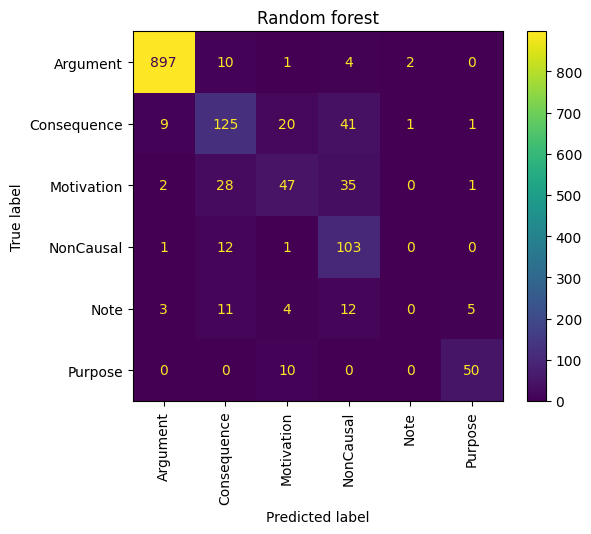

In [31]:
classifier2 = RandomForestClassifier(random_state=42).fit(x_train, y_train)

pred_train = classifier2.predict(x_train)
pred_test = classifier2.predict(x_test)

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))


cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
cm_display.plot()
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.title('Random forest')
plt.savefig('causal_chaos/random_forest')
plt.show()

In [32]:
pred = classifier2.predict(x)
pred_labels = le.inverse_transform(pred)
results_df['RandomForestPredictions'] = pred_labels
print(results_df)

                                                   Text        Label  \
0                                                    so      Purpose   
1     the judge oscar magi could decide whether to s...     Argument   
2                       the trial adjourned for 10 days     Argument   
3                                                 while  Consequence   
4     the constitutional court rules on whether pros...     Argument   
...                                                 ...          ...   
7173          the court grants a preliminary injunction     Argument   
7174  the ftc must begin administrative proceedings ...     Argument   
7175                                             within    NonCausal   
7176  the ftc must begin administrative proceedings ...     Argument   
7177                                                 to         Note   

     DecisionTreePredictions RandomForestPredictions  
0                 Motivation              Motivation  
1                   Argum

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

num_epochs = 10
num_train_steps = x_train.shape[0] * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history = bert_model.fit(x_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2)
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BERT training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('causal_chaos/bert_training')
plt.show()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
144/144 [==============================] - 4194s 29s/step - loss: 0.7850 - accuracy: 0.7137 - val_loss: 0.5399 - val_accuracy: 0.7659
Epoch 2/10
144/144 [==============================] - 4035s 28s/step - loss: 0.4857 - accuracy: 0.8147 - val_loss: 0.4745 - val_accuracy: 0.8120
Epoch 3/10
144/144 [==============================] - 4094s 28s/step - loss: 0.3733 - accuracy: 0.8633 - val_loss: 0.3680 - val_accuracy: 0.8573
Epoch 4/10
 90/144 [=================>............] - ETA: 23:26 - loss: 0.3425 - accuracy: 0.8653

In [ ]:
pred_train = np.argmax(bert_model.predict(x_train).logits, axis=1)
pred_test  = np.argmax(bert_model.predict(x_test).logits, axis=1)

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))


cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.title('BERT')
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.savefig('causal_chaos/confusion_matrix_bert')
plt.show()

In [ ]:
pred = np.argmax(bert_model.predict(x).logits, axis=1)
pred_labels = le.inverse_transform(pred)
results_df['BERTPredictions'] = pred_labels
print(results_df)

In [ ]:
x = tokenized
y = to_categorical(df['EncodedLabels'].values)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [ ]:
vocab_size = len(tokenizer.get_vocab())
embedding_dim = 768 # for bert base
max_sequence_length = x_train.shape[1]  # Set this to the same value you used for padding


model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2()),
    Dense(6, activation='softmax', kernel_regularizer=l2(), bias_regularizer=l2())
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(x_train, y_train, epochs=50, batch_size=32,  validation_split=0.2)

print(model1.summary())

print()
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('causal_chaos/LSTM_training')
plt.show()

In [ ]:
pred_train = model1.predict(x_train)
pred_test = model1.predict(x_test)

print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), np.argmax(pred_train, axis=1)))
print()
print('Test set report')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1)))

cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.title('LSTM')
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.savefig('causal_chaos/confusion_matrix_lstm')
plt.show()

In [ ]:
pred = np.argmax(model1.predict(x), axis=1)
pred_labels = le.inverse_transform(pred)
results_df['LSTM1Predictions'] = pred_labels
print(results_df)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

sentences = df.Text.values
#longest sequence should be 68 tokens so 128 should be enough, even if bert splits words
tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

sequence_len = 0
for seq in tokenized:
  if len(seq) > sequence_len:
    sequence_len = len(seq)

tokenized = pad_sequences(tokenized, maxlen=sequence_len, padding='post')

In [ ]:
x = tokenized
y = df['EncodedLabels'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [ ]:
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

num_epochs = 10
num_train_steps = x_train.shape[0] * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

distilbert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history = distilbert_model.fit(x_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2)
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DistilBERT training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('causal_chaos/distilbert_training')
plt.show()

In [ ]:
pred_train = np.argmax(distilbert_model.predict(x_train).logits, axis=1)
pred_test  = np.argmax(distilbert_model.predict(x_test).logits, axis=1)

print('Training set report')
print(classification_report(y_train, pred_train))
print()
print('Test set report')
print(classification_report(y_test, pred_test))


cm = metrics.confusion_matrix(y_test, pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot()
plt.title('DistilBERT')
plt.xticks(np.arange(classes.shape[0]), classes, rotation='vertical')
plt.savefig('causal_chaos/confusion_matrix_distilbert')
plt.show()

In [ ]:
pred = np.argmax(distilbert_model.predict(x).logits, axis=1)
pred_labels = le.inverse_transform(pred)
results_df['DistilBERTPredictions'] = pred_labels
print(results_df)

In [ ]:
results_df.to_csv('causal_chaos/results.csv')

In [ ]:
!zip -r results_causal_chaos.zip causal_chaos